In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


### Importing Libraries and Data

In [32]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [33]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
train_file = 'train.csv'
train_df = pd.read_csv(train_file)
train_df.head()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0


In [35]:
# check class distribution
train_df['label'].value_counts(normalize = True)

0    0.4200
1    0.3235
2    0.2565
Name: label, dtype: float64

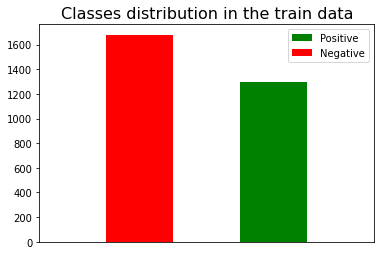

In [36]:
plt.hist(train_df[train_df.label == 1].label,
         bins=2, color='green', label='Positive')
plt.hist(train_df[train_df.label == 0].label,
         bins=2, color='red', label='Negative')
plt.title('Classes distribution in the train data', fontsize=16)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [37]:
# checking if any row has null values
print(train_df.isnull().sum())

text      0
aspect    0
label     0
dtype: int64


### Pre-processing the Data

In [38]:
#keeping just the english alphabets for further processing
def tokens(words):
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                 
    return " ".join(text)  

train_df["clear_text"] = train_df['text'].apply(tokens)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,can you check whether its cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely on both milk delivery and grocery ...
2,"I get no notification, however the app is real...",notification,0,i get no notification however the app is reall...
3,"Love this app, but would love it even more if ...",view,1,love this app but would love it even more if g...
4,it does not let me load a clip on the scene,load,0,it does not let me load a clip on the scene


In [39]:
# removing the very common words which doesn't helps the model
stop_words = stopwords.words('english') + list(string.punctuation)
def stopwords(review):
    text = [word.lower() for word in review.split() if word.lower() not in stop_words]
    return " ".join(text)

train_df['clear_text'] = train_df['clear_text'].apply(stopwords)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery items
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt charts calendar...
4,it does not let me load a clip on the scene,load,0,let load clip scene


In [40]:
# The next step is the normalization of words in the corpus by transform all of different forms of the word into one. 
# The two methods that exist for this purpose are Stemming and Lemmatization. We used the Lemmatization one.
lem = WordNetLemmatizer()

def lemma(text):
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)

train_df['clear_text'] = train_df['clear_text'].apply(lemma)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt chart calendar ...
4,it does not let me load a clip on the scene,load,0,let load clip scene


In [41]:
# seperating the positive and negative labels
positive = train_df[train_df.label== 2]
neutral = train_df[train_df.label== 1]
negative = train_df[train_df.label== 0]
positive.head()

,text,aspect,label,clear_text
5,"i love notion as a tool, but the mobile just t...","tool,",2,love notion tool mobile take way long load
9,please add this basic feature,Please,2,please add basic feature
12,the desktop version is simply awesome comparat...,desktop version,2,desktop version simply awesome comparatively
14,prompt and reliable service,Prompt,2,prompt reliable service
16,"the ease of ordering, timely delivery and best...","ease of ordering,",2,ease ordering timely delivery best part use va...


In [42]:
neutral.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt chart calendar ...
6,unlimited yearly at $216/year,yearly,1,unlimited yearly year
8,Would love the ability to “un-delete” deleted ...,tasks,1,would love ability un delete deleted task app ...
11,-&gt; i want to learn for the future whether w...,learn,1,gt want learn future whether team something wr...


In [43]:
negative.head()

,text,aspect,label,clear_text
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
4,it does not let me load a clip on the scene,load,0,let load clip scene
7,"some times missing to deliver, some times diff...","deliver,",0,time missing deliver time different order deli...
10,so i wanted to download the app.,app,0,wanted download app


In [44]:
# creating a list containing positive words
positive_words =[]

for review in positive.clear_text:
    positive_words.append(review) 
positive_words = ' '.join(positive_words)
positive_words[:48]

'love notion tool mobile take way long load pleas'

In [45]:
# creating a list containing neutral words
neutral_words =[]

for review in neutral.clear_text:
    neutral_words.append(review) 
neutral_words = ' '.join(neutral_words)
neutral_words[:48]

'check whether cancelled completely love app woul'

In [46]:
# creating a list containing positive words
negative_words = []

for review in negative.clear_text:
    negative_words.append(review)
negative_words = ' '.join(negative_words)
negative_words[:45]

'cannot rely milk delivery grocery item get no'

### Observations

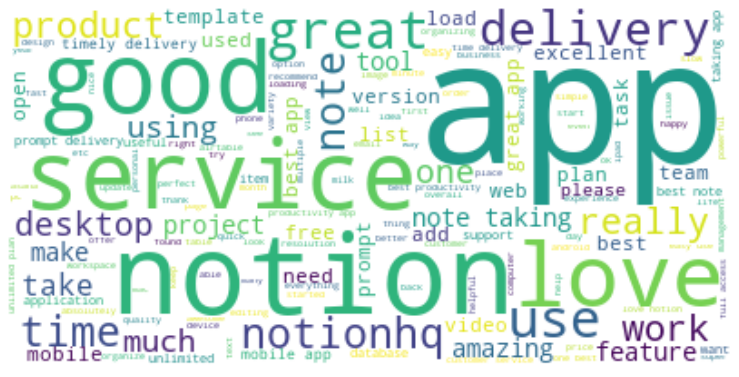

In [47]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=len(positive_words))

wordcloud.generate(positive_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

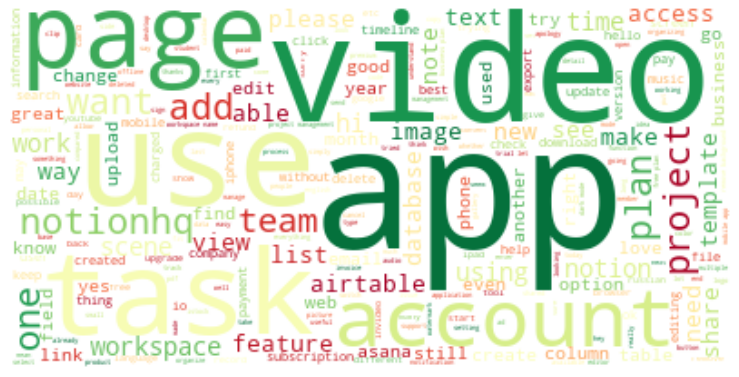

In [48]:
wordcloud = WordCloud(background_color="white", max_words=len(neutral_words), colormap='RdYlGn')

wordcloud.generate(neutral_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

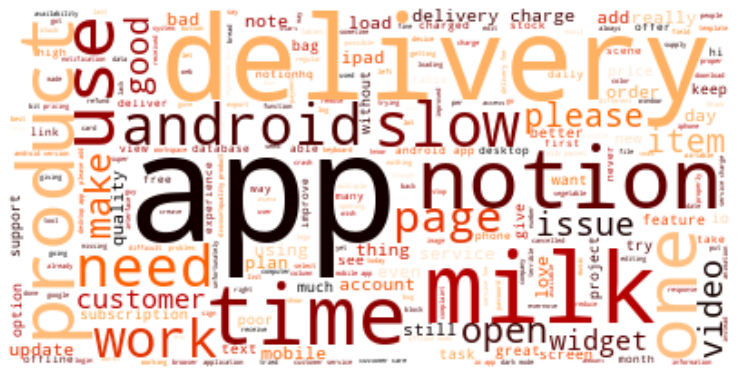

In [49]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_words), colormap='gist_heat')

wordcloud.generate(negative_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Model Training

In [52]:
# droping the neutral statements because they don't contribute to out model
train_df = train_df[train_df.label != 1]
train_df.head()

,text,aspect,label,clear_text
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
4,it does not let me load a clip on the scene,load,0,let load clip scene
5,"i love notion as a tool, but the mobile just t...","tool,",2,love notion tool mobile take way long load
7,"some times missing to deliver, some times diff...","deliver,",0,time missing deliver time different order deli...


In [53]:
# dividing the train and test set
X = train_df['clear_text']
y = train_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [54]:
# vectorising the X_data (because compuer doesn't understands alphabets)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)

X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)

len(vect.get_feature_names())

755

In [55]:
# training the  model using Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
# taking the prediction on test set
ytest = np.array(y_test)
predictions = model.predict(X_test_vectorized)

In [57]:
# checking the accuracy
print('accuracy %s' % accuracy_score(predictions, y_test))
print(classification_report(ytest, predictions))

accuracy 0.7712177121771218
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       345
           2       0.71      0.62      0.66       197

    accuracy                           0.77       542
   macro avg       0.76      0.74      0.75       542
weighted avg       0.77      0.77      0.77       542



In [58]:
# training the model using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
model_rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('clf-rf', RandomForestClassifier(n_estimators=50)),
                    ])

model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [59]:
# taking the prediction
ytest = np.array(y_test)
pred = model_rf.predict(X_test)

In [60]:
# checking the accuracy
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.7435424354243543
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       345
           2       0.66      0.61      0.64       197

    accuracy                           0.74       542
   macro avg       0.72      0.72      0.72       542
weighted avg       0.74      0.74      0.74       542

